In [1]:
import pandas as pd

# TODO: show correlation with Transported for Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
# TODO: handle outliers (use feature clipping)
# https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/
# https://scikit-learn.org/stable/modules/outlier_detection.html
# https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler
# https://datascience.stackexchange.com/questions/102625/is-standardization-normalization-a-good-way-of-reducing-the-impact-of-outliers-w
# https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/
# https://stats.stackexchange.com/questions/402470/how-can-i-use-scaling-and-log-transforming-together
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html

df = pd.read_csv('data/train.csv')
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [2]:
# Count missing values in a dataframe
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [3]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [4]:
print('0.0 values for each column:')
cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in cols:
    print(col, sum(df[col].values == 0.0))

0.0 values for each column:
RoomService 5577
FoodCourt 5456
ShoppingMall 5587
Spa 5324
VRDeck 5495


In [5]:
import numpy as np
import math

def get_null_indicies_for_column(df, column):
    return sorted([idx for idx, missing in df[column].isnull().items() if missing])

vip_null_indicies = get_null_indicies_for_column(df, 'VIP')
print('indicies with null:', vip_null_indicies[0:10])
print('len', len(vip_null_indicies))
print('value of index 38:', df['VIP'][38], '/ type:', type(df['VIP'][38]))
print('isnan:', math.isnan(df['VIP'][38]))
# print(math.isnan(np.nan)) - also True

indicies with null: [38, 102, 145, 228, 566, 582, 596, 646, 649, 678]
len 203
value of index 38: nan / type: <class 'float'>
isnan: True


In [6]:
def augument_cabin(df):
    deck_values = []
    num_values = []
    side_values = []
    for val in df['Cabin']:
        if isinstance(val, str):
            tokens = val.split('/')
            assert len(tokens) == 3
            deck_values.append(tokens[0])
            num_values.append(int(tokens[1]))
            side_values.append(tokens[2])
        else:
            deck_values.append(np.nan)
            num_values.append(np.nan)
            side_values.append(np.nan)

    df['Deck'] = pd.Series(deck_values, dtype='object')
    df['CabinIndex'] = pd.Series(num_values, dtype='object')
    df['Side'] = pd.Series(side_values, dtype='object')
    
augument_cabin(df)

In [7]:
from sklearn.impute import SimpleImputer

# print(df['VIP'].value_counts(dropna=False))
# print(df['VIP'].values.reshape(-1, 1).shape)
# print(df['VIP'].values.reshape(-1, 1)[:, 0].shape)

def impute_general_cols(df):
    cat_and_bool_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    values_before_imputer = df[['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']].values
    values_after_imputer = cat_and_bool_imputer.fit_transform(values_before_imputer)

    df['HomePlanet'] = pd.Series(values_after_imputer[:, 0], dtype='category')
    df['CryoSleep'] = pd.Series(values_after_imputer[:, 1], dtype=bool)
    df['Destination'] = pd.Series(values_after_imputer[:, 2], dtype='category')
    df['VIP'] = pd.Series(values_after_imputer[:, 3], dtype=bool)
    df['Deck'] = pd.Series(values_after_imputer[:, 4], dtype='category')
    df['Side'] = pd.Series(values_after_imputer[:, 5], dtype='category')

    expenses_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    expenses_imputer = SimpleImputer(missing_values=np.nan, strategy='constant')
    values_before_imputer = df[expenses_columns].values
    values_after_imputer = expenses_imputer.fit_transform(values_before_imputer)

    for idx, col in enumerate(expenses_columns):
        df[col] = pd.Series(values_after_imputer[:, idx], dtype='float64')

    age_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    values_before_imputer = df[['Age']].values
    values_after_imputer = age_imputer.fit_transform(values_before_imputer)
    df['Age'] = pd.Series(values_after_imputer[:, 0], dtype='float64')

impute_general_cols(df)

In [8]:
def impute_name(df):
    name_values = df['Name'].values
    passenger_id_values = df['PassengerId'].values
    name_null_indicies = np.argwhere(df['Name'].isnull().values).flatten()
    name_values[name_null_indicies] = 'UnknownName_' + passenger_id_values[name_null_indicies]
    df['Name'] = pd.Series(name_values, dtype='object')
    
impute_name(df)

In [9]:
def impute_cabin_index(df):
    cabin_index_values = df['CabinIndex'].values
    cabin_index_null_indicies = np.argwhere(df['CabinIndex'].isnull().values).flatten()
    cabin_index_values[cabin_index_null_indicies] = list(range(len(cabin_index_null_indicies)))
    df['CabinIndex'] = pd.Series(cabin_index_values, dtype='int32')
    
def fill_cabin(df):
    cabin_values = df['Cabin'].values
    cabin_null_indicies = np.argwhere(df['Cabin'].isnull().values).flatten()
    for idx in cabin_null_indicies:
        item = df.iloc[idx]
        cabin_values[idx] = '{}/{}/{}'.format(item['Deck'], str(item['CabinIndex']), item['Side'])
    df['Cabin'] = pd.Series(cabin_values, dtype='object')
    
impute_cabin_index(df)
fill_cabin(df)

In [10]:
def augument_group_size(df):
    col_data = [val.split('_') for val in df['PassengerId']]
    counter = {}
    for group_id, group_pos in col_data:
        if group_id not in counter:
            counter[group_id] = 0
        counter[group_id] += 1

    group_size = []
    for group_id, group_pos in col_data:
        group_size.append(counter[group_id])
    df['GroupSize'] = pd.Series(group_size, dtype='int32')
    
augument_group_size(df)

In [11]:
def transform_price_columns(df):
    cols = ['ShoppingMall', 'RoomService', 'FoodCourt', 'Spa', 'VRDeck']
    for col in cols:
        df[col] = pd.Series(np.log1p(df[col].values))
        
transform_price_columns(df)

In [12]:
df.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
Deck            0
CabinIndex      0
Side            0
GroupSize       0
dtype: int64

In [13]:
df.dtypes

PassengerId       object
HomePlanet      category
CryoSleep           bool
Cabin             object
Destination     category
Age              float64
VIP                 bool
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Name              object
Transported         bool
Deck            category
CabinIndex         int32
Side            category
GroupSize          int32
dtype: object

In [14]:
df['CabinIndex'].value_counts()

82      29
86      23
19      23
176     22
56      22
        ..
1644     1
1515     1
1639     1
1277     1
1894     1
Name: CabinIndex, Length: 1817, dtype: int64

In [15]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabinIndex,Side,GroupSize
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False,B,0,P,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,4.700480,2.302585,3.258097,6.309918,3.806662,Juanna Vines,True,F,0,S,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,3.784190,8.182280,0.000000,8.812248,3.912023,Altark Susent,False,A,0,S,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.000000,7.157735,5.918894,8.110728,5.267858,Solam Susent,False,A,0,S,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,5.717028,4.262680,5.023881,6.338594,1.098612,Willy Santantines,True,F,1,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.000000,8.827615,0.000000,7.404888,4.317488,Gravior Noxnuther,False,A,98,P,1
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,Kurta Mondalley,False,G,1499,S,1
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.000000,0.000000,7.535297,0.693147,0.000000,Fayey Connon,True,G,1500,S,1
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.000000,6.956545,0.000000,5.869297,8.082093,Celeon Hontichre,False,E,608,S,2


In [16]:
df2 = pd.get_dummies(df, columns=['HomePlanet', 'Destination', 'Deck', 'Side'], drop_first=True)
# print(list(enumerate(df2.columns)))
df2.rename(columns={'Destination_55 Cancri e': 'Dest_Cancri',
                    'Destination_PSO J318.5-22': 'Dest_PSO',
                    'Destination_TRAPPIST-1e': 'Dest_TRAPPIST'}, inplace=True)
# df2.iloc[:, 13:]

In [17]:
# df2 = df[['CryoSleep']]
# df2['CryoSleep'] = df2['CryoSleep'].astype(dtype='int32')
# df2

# bool_cols = ['CryoSleep', 'VIP', 'Transported']
# for col_name in bool_cols:
#     df[col_name] = df[col_name].astype(dtype='int32')
    
# df

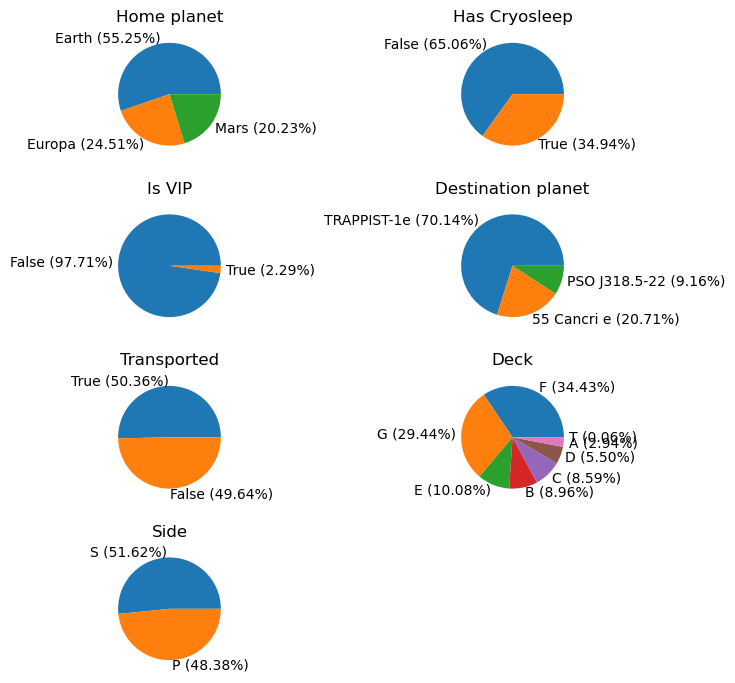

In [18]:
import matplotlib.pyplot as plt

def show_pie_chart_for_column(df, column, ax=None, title=None, with_percent=True):
    labels, values = [], []
    for label, val in df[column].value_counts().items():
        if isinstance(label, (bool, int)):
            label = str(label)
        if with_percent:
            percent = (val / len(df[column])) * 100.0
            label += f' ({percent:.2f}%)'
        labels.append(label)
        values.append(val)

    if not ax:
        fig, ax = plt.subplots()
    if title:
        ax.set_title(title)
    ax.pie(values, labels=labels)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(7, 7))
fig.tight_layout(pad=1.0)

show_pie_chart_for_column(df, 'HomePlanet', ax=axs[0, 0], title='Home planet')
show_pie_chart_for_column(df, 'CryoSleep', ax=axs[0, 1], title='Has Cryosleep')
show_pie_chart_for_column(df, 'VIP', ax=axs[1, 0], title='Is VIP')
show_pie_chart_for_column(df, 'Destination', ax=axs[1, 1], title='Destination planet')
show_pie_chart_for_column(df, 'Transported', ax=axs[2, 0], title='Transported')
show_pie_chart_for_column(df, 'Deck', ax=axs[2, 1], title='Deck')
show_pie_chart_for_column(df, 'Side', ax=axs[3, 0], title='Side')
axs[3, 1].axis('off')

plt.show()

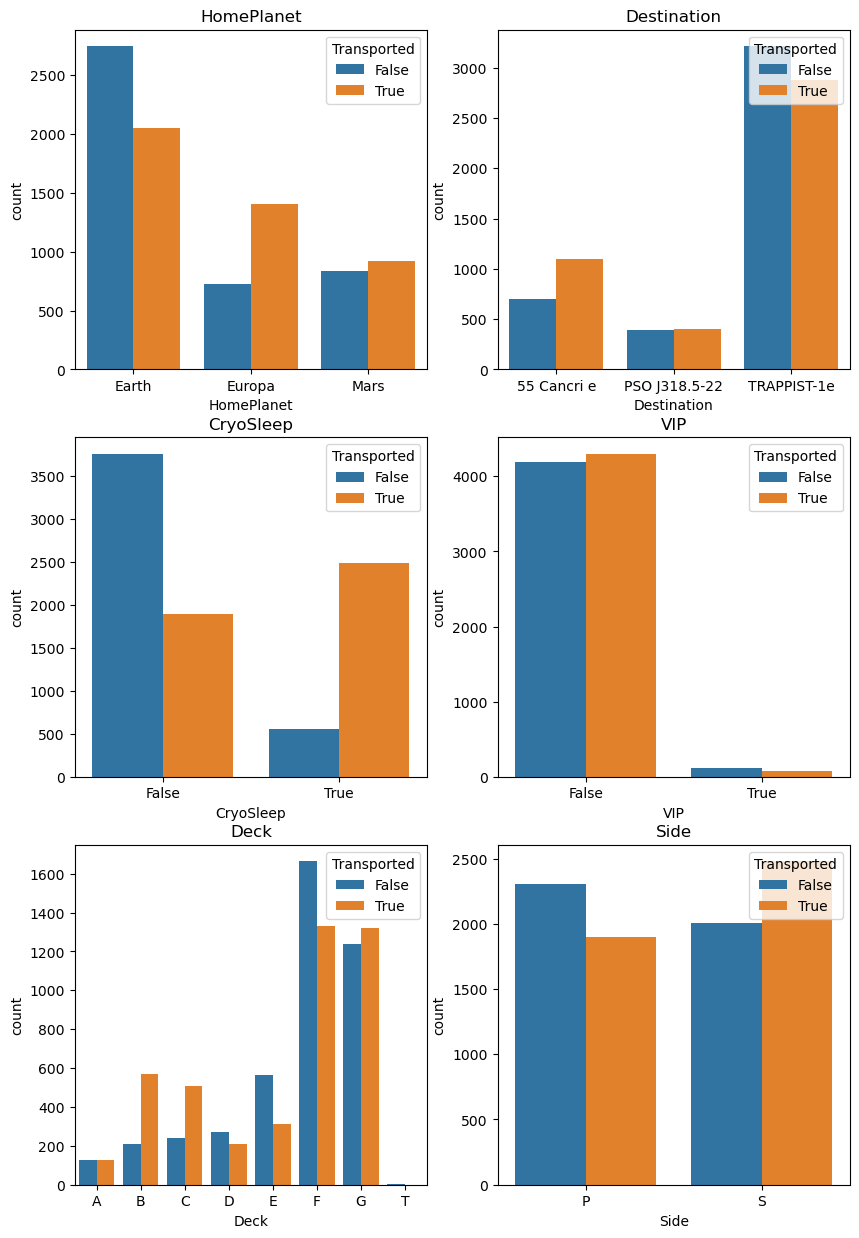

In [19]:
import seaborn as sns

cols_to_visualise = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'Deck', 'Side']
plot_size = 5
n_rows = 3
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * plot_size, n_rows * plot_size))
for row_idx in range(n_rows):
    for col_idx in range(n_cols):
        i = row_idx * n_cols + col_idx
        ax = axs[row_idx, col_idx]
        col_name = cols_to_visualise[i]
        series = df[col_name]
        sns.countplot(x=series,
                      hue=df['Transported'],
                      ax=ax)
        ax.set_title(col_name)
        ax.legend(title='Transported', loc='upper right')

plt.show()

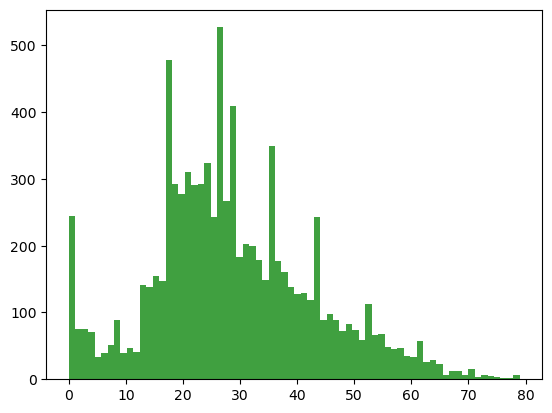

In [20]:
plt.hist(df['Age'].values, 70, facecolor='g', alpha=0.75)
plt.show()

col "RoomService" max value: 9.569970943740548
all values count: 8693
non null values count: 2935


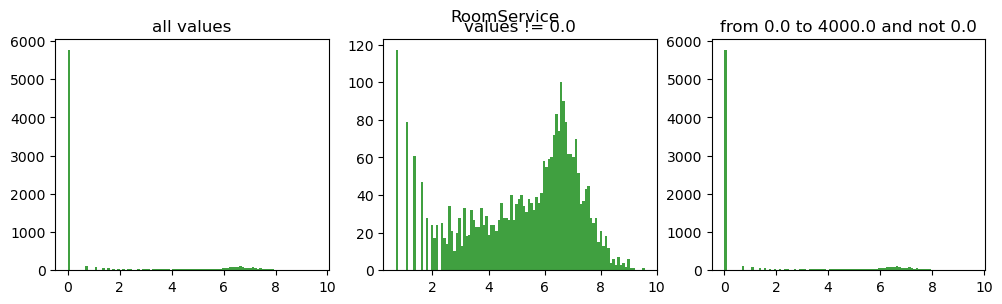

In [21]:
def show_hist_diagram(df, col_name, title=None, border=None):
    fig, axs = plt.subplots(nrows=1, ncols=3 if border else 2, figsize=(12, 3))
    # fig.tight_layout(pad=2.0)
    
    all_values = df[col_name].values
    non_null_values = df[col_name].loc[lambda x : x != 0.0].values

    axs[0].hist(all_values, 100, facecolor='g', alpha=0.75)
    axs[0].set_title('all values')
    axs[1].hist(non_null_values, 100, facecolor='g', alpha=0.75)
    axs[1].set_title('values != 0.0')
    if border:
        # TODO: fix exception if x != 0.0 is specified 
        axs[2].hist(df[col_name].where(lambda x: (x <= border)).values, 100, facecolor='g', alpha=0.75)
        axs[2].set_title(f'from 0.0 to {border} and not 0.0')
    
    if title is None:
        title = col_name
    fig.suptitle(title)
    
    print(f'col "{col_name}" max value: {max(df[col_name])}')
    print(f'all values count: {len(all_values)}')
    print(f'non null values count: {len(non_null_values)}')

show_hist_diagram(df, 'RoomService', border=4000.0)
plt.show()

col "FoodCourt" max value: 10.302733360830375
all values count: 8693
non null values count: 3054


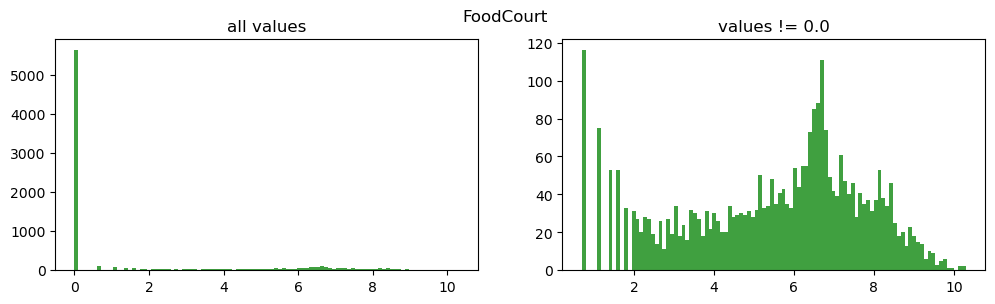

In [22]:
show_hist_diagram(df, 'FoodCourt')
plt.show()

col "ShoppingMall" max value: 10.064457783419048
all values count: 8693
non null values count: 2898


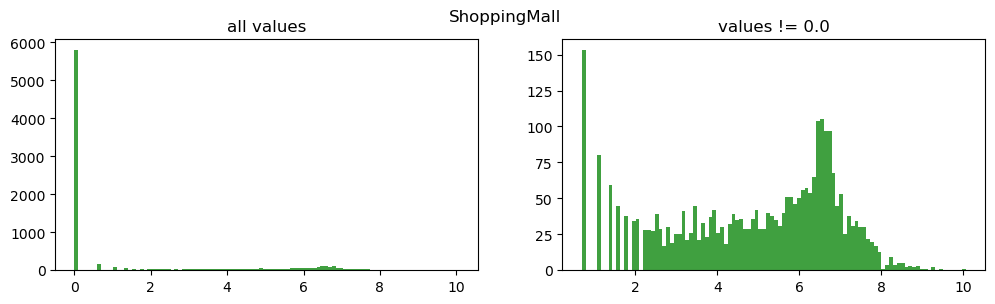

In [23]:
show_hist_diagram(df, 'ShoppingMall')
plt.show()

col "Spa" max value: 10.01721794286315
all values count: 8693
non null values count: 3186


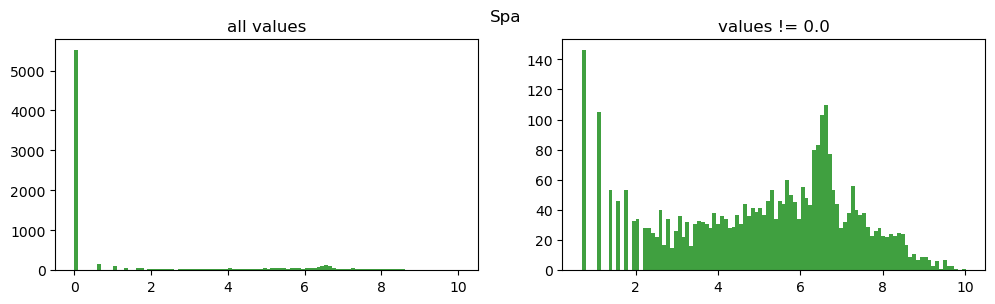

In [24]:
show_hist_diagram(df, 'Spa')
plt.show()

col "VRDeck" max value: 10.091376913633546
all values count: 8693
non null values count: 3010


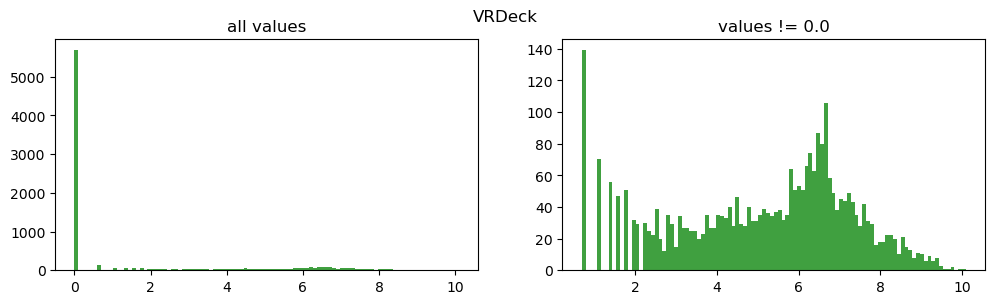

In [25]:
show_hist_diagram(df, 'VRDeck')
plt.show()

In [26]:
print(df['RoomService'].loc[lambda x: x != 0.0])
print(df['RoomService'].loc[lambda x: x == 0.0])
print(len(df['RoomService'].loc[lambda x: x <= 4000.0]))

1       4.700480
2       3.784190
4       5.717028
6       3.761200
11      3.688879
          ...   
8675    6.938284
8682    5.484797
8683    4.465908
8686    0.693147
8692    4.844187
Name: RoomService, Length: 2935, dtype: float64
0       0.0
3       0.0
5       0.0
7       0.0
8       0.0
       ... 
8687    0.0
8688    0.0
8689    0.0
8690    0.0
8691    0.0
Name: RoomService, Length: 5758, dtype: float64
8693


In [27]:
max(df['RoomService'])

9.569970943740548

In [28]:
from sklearn.preprocessing import StandardScaler
vrdeck = df['VRDeck'].values 
print(np.argwhere((vrdeck > 3000) & (vrdeck < 4000)).flatten())

idxes = [0, 1, 4311, 5619]
idxes.extend(list(np.argwhere((vrdeck > 3000) & (vrdeck < 4000)).flatten()))
idxes.extend(list(np.argwhere(vrdeck > 10000).flatten()))

std_scaler = StandardScaler()
vrdeck_std = std_scaler.fit_transform(vrdeck.reshape(-1, 1))

# for idx in idxes:
#     print(f'initial: {vrdeck[idx]} / std: {vrdeck_std[idx]}')

example_data = np.linspace(0, 20000, 21)
example_data_std = std_scaler.transform(example_data.reshape(-1, 1))

for i in range(len(example_data)):
    print(f'initial: {example_data[i]} / std: {example_data_std[i]}')

print(std_scaler.scale_, std_scaler.mean_, std_scaler.var_)
print(np.mean(vrdeck))
print(np.var(vrdeck))
print(np.sqrt(np.var(vrdeck)))

[]
initial: 0.0 / std: [-0.64003376]
initial: 1000.0 / std: [363.43958904]
initial: 2000.0 / std: [727.51921185]
initial: 3000.0 / std: [1091.59883466]
initial: 4000.0 / std: [1455.67845747]
initial: 5000.0 / std: [1819.75808028]
initial: 6000.0 / std: [2183.83770309]
initial: 7000.0 / std: [2547.9173259]
initial: 8000.0 / std: [2911.99694871]
initial: 9000.0 / std: [3276.07657151]
initial: 10000.0 / std: [3640.15619432]
initial: 11000.0 / std: [4004.23581713]
initial: 12000.0 / std: [4368.31543994]
initial: 13000.0 / std: [4732.39506275]
initial: 14000.0 / std: [5096.47468556]
initial: 15000.0 / std: [5460.55430837]
initial: 16000.0 / std: [5824.63393118]
initial: 17000.0 / std: [6188.71355399]
initial: 18000.0 / std: [6552.79317679]
initial: 19000.0 / std: [6916.8727996]
initial: 20000.0 / std: [7280.95242241]
[2.74665193] [1.75794998] [7.54409684]
1.7579499766576159
7.544096844768722
2.7466519336764756


In [29]:
from sklearn.preprocessing import RobustScaler

vrdeck = df['VRDeck'].values
print(np.median(vrdeck))
print(np.quantile(vrdeck, 0.25))
print(np.quantile(vrdeck, 0.5))
print(np.quantile(vrdeck, 0.75))

idxes = [0, 1, 4311, 5619]
idxes.extend(list(np.argwhere((vrdeck > 3000) & (vrdeck < 4000)).flatten()))
idxes.extend(list(np.argwhere(vrdeck > 10000).flatten()))

robust_scaler = RobustScaler()
vrdeck_robust = robust_scaler.fit_transform(vrdeck.reshape(-1, 1))

example_data = np.linspace(0, 20000, 21)
example_data_robust = robust_scaler.transform(example_data.reshape(-1, 1))

for i in range(len(example_data)):
    print(f'initial: {example_data[i]} / std: {example_data_robust[i]}')
    
vrdeck_q1 = np.quantile(vrdeck, 0.25)
vrdeck_q3 = np.quantile(vrdeck, 0.75)
vrdeck_median = np.median(vrdeck)

# Same values as before
# example_data_robust = (example_data - vrdeck_median) / (vrdeck_q3 - vrdeck_q1)
# for i in range(len(example_data)):
#     print(f'initial: {example_data[i]} / std: {example_data_robust[i]}')

0.0
0.0
0.0
3.713572066704308
initial: 0.0 / std: [0.]
initial: 1000.0 / std: [269.28250806]
initial: 2000.0 / std: [538.56501613]
initial: 3000.0 / std: [807.84752419]
initial: 4000.0 / std: [1077.13003226]
initial: 5000.0 / std: [1346.41254032]
initial: 6000.0 / std: [1615.69504839]
initial: 7000.0 / std: [1884.97755645]
initial: 8000.0 / std: [2154.26006452]
initial: 9000.0 / std: [2423.54257258]
initial: 10000.0 / std: [2692.82508064]
initial: 11000.0 / std: [2962.10758871]
initial: 12000.0 / std: [3231.39009677]
initial: 13000.0 / std: [3500.67260484]
initial: 14000.0 / std: [3769.9551129]
initial: 15000.0 / std: [4039.23762097]
initial: 16000.0 / std: [4308.52012903]
initial: 17000.0 / std: [4577.80263709]
initial: 18000.0 / std: [4847.08514516]
initial: 19000.0 / std: [5116.36765322]
initial: 20000.0 / std: [5385.65016129]


In [30]:
iqr = vrdeck_q3 - vrdeck_q1
iqr

3.713572066704308

In [31]:
cols = ['ShoppingMall', 'RoomService', 'FoodCourt', 'Spa', 'VRDeck']
for col in cols:
    ser = df[col].values
    q1 = np.quantile(ser, 0.25)
    q3 = np.quantile(ser, 0.75)
    iqr = q3 - q1
    up_limit = q3 + 1.5 * iqr
    outliner_count = len(df[col].loc[lambda v: v > up_limit].values)
    print(f'{col} {outliner_count}')

ShoppingMall 72
RoomService 1
FoodCourt 0
Spa 1
VRDeck 23


In [32]:
pivot_df = pd.DataFrame()
cols = [('ShoppingMall', 'SM'), ('RoomService', 'RS'), ('FoodCourt', 'FC'), ('Spa', 'Spa'), ('VRDeck', 'VR')]
for col, short_col_name in cols:
    s = pd.cut(df[col].values, [-0.01, 2, 4, 6, 8, 10, 12])
    table = df.pivot_table('Transported', s)
    pivot_df[f'{short_col_name}_Count'] = s.value_counts()
    pivot_df[f'{short_col_name}_T'] = table['Transported']

pivot_df

,SM_Count,SM_T,RS_Count,RS_T,FC_Count,FC_T,Spa_Count,Spa_T,VR_Count,VR_T
"(-0.01, 2.0]",6204,0.574146,6114,0.611711,6000,0.566667,5943,0.618543,6078,0.608259
"(2.0, 4.0]",599,0.203673,486,0.376543,485,0.189691,578,0.359862,533,0.365854
"(4.0, 6.0]",765,0.223529,748,0.330214,691,0.260492,864,0.328704,800,0.311250
"(6.0, 8.0]",1081,0.451434,1250,0.161600,1121,0.402319,1079,0.190918,1067,0.214620
"(8.0, 10.0]",43,0.790698,95,0.063158,392,0.640306,228,0.017544,214,0.037383
"(10.0, 12.0]",1,1.000000,0,NaN,4,1.000000,1,0.000000,1,0.000000


In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

final_columns = ['CryoSleep', 'Age', 'VIP', 'RoomService', 'GroupSize', 'HomePlanet_Europa', 'HomePlanet_Mars',
                 'Dest_PSO', 'Dest_TRAPPIST', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
                 'Deck_T', 'Side_S']

def df_dataset_to_np(df, with_y=True):
    df2 = df[['CryoSleep', 'Age', 'VIP', 'RoomService', 'GroupSize']]
    for col in ('CryoSleep', 'VIP'):
        df2[col] = df2[col].astype(int)

    X_cat = df[['HomePlanet', 'Destination', 'Deck', 'Side']].values
    one_hot_encoder = OneHotEncoder(categories='auto', drop='first')
    col_transformer = ColumnTransformer([
        ('HomePlanet_onehot', one_hot_encoder, [0]),
        ('Destination_onehot', one_hot_encoder, [1]),
        ('Deck_onehot', one_hot_encoder, [2]),
        ('Side_onehot', one_hot_encoder, [3]),
    ])
    X_cat_transformed = col_transformer.fit_transform(X_cat).toarray()
    # print(X_cat_transformed.shape)
    # X_cat_transformed
    # for i in range(4):
    #     print(col_transformer.transformers_[i][1].categories_)

    X_regular = df2.values
    X = np.hstack((X_regular, X_cat_transformed))
    # print(X.shape)
    if with_y:
        y = df['Transported'].astype(int).values
        return X, y
    else:
        return X

X, y = df_dataset_to_np(df)
X

/tmp/ipykernel_2713/2221891377.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = df2[col].astype(int)


array([[ 0., 39.,  0., ...,  0.,  0.,  0.],
       [ 0., 24.,  0., ...,  0.,  0.,  1.],
       [ 0., 58.,  1., ...,  0.,  0.,  1.],
       ...,
       [ 0., 26.,  0., ...,  1.,  0.,  1.],
       [ 0., 32.,  0., ...,  0.,  0.,  1.],
       [ 0., 44.,  0., ...,  0.,  0.,  1.]])

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

log_reg_pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=10, solver='lbfgs', random_state=1)
)
log_reg_pipe.fit(X_train, y_train)

print('Log reg train score:', log_reg_pipe.score(X_train, y_train))
print('Log reg test score:', log_reg_pipe.score(X_test, y_test))

Log reg train score: 0.7238840312931432
Log reg test score: 0.7332106715731371


In [36]:
from sklearn.model_selection import GridSearchCV

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'logisticregression__C': param_range}]
grid_search = GridSearchCV(
    estimator=log_reg_pipe,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    refit=True,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print('best_score:', grid_search.best_score_)
print('best_params:', grid_search.best_params_)

best_score: 0.7203591925588759
best_params: {'logisticregression__C': 0.1}


In [37]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)
forest.fit(X_train, y_train)

print('RandomForest train score:', forest.score(X_train, y_train))
print('RandomForest test score:', forest.score(X_test, y_test))

importances = forest.feature_importances_
print(importances)

items = zip(final_columns, importances) 
sorted(items, key=lambda v: v[1], reverse=True)

RandomForest train score: 0.9375671115201718
RandomForest test score: 0.7014719411223551
[1.81217061e-01 3.58742970e-01 5.78309089e-03 2.01594569e-01
 7.96608645e-02 1.88290178e-02 2.38635112e-02 1.03604426e-02
 2.20749549e-02 8.38150387e-03 8.85427330e-03 6.62428741e-03
 1.40033861e-02 1.59338934e-02 1.75892886e-02 2.08001916e-04
 2.62788831e-02]


[('Age', 0.3587429704499815),
 ('RoomService', 0.2015945692044512),
 ('CryoSleep', 0.18121706071173097),
 ('GroupSize', 0.07966086449482429),
 ('Side_S', 0.02627888306371346),
 ('HomePlanet_Mars', 0.023863511179589885),
 ('Dest_TRAPPIST', 0.0220749549204146),
 ('HomePlanet_Europa', 0.018829017823327254),
 ('Deck_G', 0.01758928863718537),
 ('Deck_F', 0.01593389335196498),
 ('Deck_E', 0.014003386147106767),
 ('Dest_PSO', 0.010360442633452201),
 ('Deck_C', 0.00885427329643283),
 ('Deck_B', 0.008381503866714905),
 ('Deck_D', 0.006624287410552387),
 ('VIP', 0.005783090892352364),
 ('Deck_T', 0.00020800191620504987)]

In [49]:
df_test = pd.read_csv('data/test.csv')
# grid_search.predict

augument_cabin(df_test)
impute_general_cols(df_test)
impute_name(df_test)
impute_cabin_index(df_test)
fill_cabin(df_test)
augument_group_size(df_test)
transform_price_columns(df_test)

X_submit = df_dataset_to_np(df_test, with_y=False)
y_submit = grid_search.predict(X_submit)
y_submit

answer_ser = pd.Series(y_submit, dtype='int32').astype(bool)
df_submit = pd.read_csv('data/sample_submission.csv')
df_submit['Transported'] = answer_ser
df_submit.to_csv('answer.csv', index=False)
df_submit

/tmp/ipykernel_2713/2221891377.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = df2[col].astype(int)


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False
